In [1]:
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import json
# from google.colab.patches import cv2_imshow

In [2]:
!unzip -qq cards2.zip

In [3]:
!ls -l

total 56712
drwxr-xr-x 4 ubuntu ubuntu       59 Jun 19 08:52 asdf
-rw-rw-r-- 1 ubuntu ubuntu 29035658 Jun 21 18:21 asdf.ipynb
drwxrwxr-x 4 ubuntu ubuntu       93 Jun 21 18:16 data
-rw-rw-r-- 1 ubuntu ubuntu 29035658 Jun 21 18:21 ttt.ipynb


In [4]:
labels = {
    'id':0,
    'drive':1,
    'credit':2
}


In [5]:
for root, dirs, filenames in os.walk('./'):
    for filename in filenames:
        first, last = os.path.splitext(filename)

        if last != '.jpg':
            continue
        
        json_path = os.path.join(root, first + '.json')
        if not os.path.exists(json_path):
            continue
        
        data = json.load(open(json_path, 'r'))
        if data['shapes'][0]['label'] not in labels:
            print(data['shapes'][0]['label'], json_path)

card ./data/train/신준호Label/junho_card.json
credit2 ./data/train/장문정/Inked1.png_LI1.json
credit1 ./data/train/장문정/Inked2.png_LI.json


In [6]:
json_path

'./data/valid/이동휘cardlabel/KakaoTalk_20210615_093846988_02.json'

In [7]:
label_alt = {
    'credit2':'credit',
    'credit1':'credit',
    'card':'credit',
}

In [8]:
def sort_points(points):
    s = points.sum(axis=1)
    lt = s.argmin()
    rb = s.argmax()
    m = points[:, 1] - points[:, 0]
    lb = m.argmax()
    rt = m.argmin()
    if len({lt, rb, lb, rt}) < 4:
        return None
    return points[(lt, rt, rb, lb), :]

In [34]:
cards_data_train = []
cards_data_valid = []
for root, dirs, filenames in os.walk('./'):
    for filename in filenames:
        first, last = os.path.splitext(filename)

        if last != '.jpg':
            continue
        
        json_path = os.path.join(root, first + '.json')
        if not os.path.exists(json_path):
            continue
        
        jpg_path = os.path.join(root, filename)
        data = json.load(open(json_path, 'r'))
        label_txt = data['shapes'][0]['label']
        if label_txt in label_alt:
            label_txt = label_alt[label_txt]
        label = labels[label_txt]
        # if label == 2:
        #     continue

        points = data['shapes'][0]['points']
        points = np.array(points, dtype=np.float32)
        points = sort_points(points)
        points = points.reshape(-1)

        if 'train' in root:
            cards_data_train.append((jpg_path, label, points))
        else:
            cards_data_valid.append((jpg_path, label, points))

In [10]:
print(len([item for item in cards_data_valid if item[1] == 2]))

0


In [35]:
def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def floats_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def write_tfrecord(cards_data, tfrecord_path):
    writer = tf.io.TFRecordWriter(tfrecord_path)
    cards_data = cards_data_train
    for jpg_path, label, points in cards_data:
        file = open(jpg_path, 'rb')
        feat_dict = {}
        feat_dict['image'] = bytes_feature([file.read()])
        feat_dict['label'] = int64_feature([label])
        feat_dict['points'] = floats_feature(points)
        file.close()

        example = tf.train.Example(features=tf.train.Features(feature=feat_dict))
        writer.write(example.SerializeToString())

    writer.close()
write_tfrecord(cards_data_train, 'data/train.tfrecord')
write_tfrecord(cards_data_valid, 'data/valid.tfrecord')

In [36]:
def read_tfrecord(example):
    tfrecord_format = (
        {
            'image':tf.io.FixedLenFeature([], tf.string),
            'label':tf.io.FixedLenFeature([], tf.int64),
            'points':tf.io.FixedLenFeature([8], tf.float32)
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.io.decode_jpeg(example['image'])
    label = example['label']
    points = example['points']
    return image, label, points

dataset_train = tf.data.TFRecordDataset('data/train.tfrecord')
dataset_valid = tf.data.TFRecordDataset('data/valid.tfrecord')
dataset_train = dataset_train.map(read_tfrecord)
dataset_valid = dataset_valid.map(read_tfrecord)

In [37]:
len(cards_data_train)

88

In [13]:
# def generator_train():
#     for path, label, points in cards_data_train:
#         image = cv2.imread(path)
#         label = np.array(label, dtype=np.int32)
#         yield (image, label, points)

# def generator_valid():
#     for path, label, points in cards_data_valid:
#         image = cv2.imread(path)
#         label = np.array(label, dtype=np.int32)
#         yield (image, label, points)

In [14]:
# dataset_train = tf.data.Dataset.from_generator(
#     generator_train,
#     (tf.uint8, tf.int32, tf.float32),
#     ((None, None, 3), (), (8,))
#     )

# dataset_valid = tf.data.Dataset.from_generator(
#     generator_valid,
#     (tf.uint8, tf.int32, tf.float32),
#     ((None, None, 3), (), (8,))
#     )


In [14]:
def draw_points(image, label, pixel=True):
    if type(image) == np.ndarray:
        image = image.copy()
        label = label.copy()
    else:
        image = image.numpy()
        label = label.numpy()
    if not pixel:
        h, w, _ = image.shape
        label = np.int32(label * ([w, h] * 4))
    pts = label.reshape([-1, 2]).astype(np.int32)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 255)]
    for i in range(4):
        i2 = (i + 1) % 4
        cv2.line(image, tuple(pts[i]), tuple(pts[i2]), colors[i], 3)
    return image

In [15]:
for image, label_id, points in dataset_train.take(3):
    # image = cv2.imread(path)
    dst = draw_points(image, points)
    cv2_imshow(dst)
    print(label_id)

NameError: name 'cv2_imshow' is not defined

In [15]:
import random

def random_geometry(image, points, image_shape, target_size):
    width, height = target_size

    card_width = width * (0.6 + random.random() * 0.35)
    card_height = card_width * (5.4 / 8.6)
    center_x = width * (0.45 + random.random() * 0.1)
    center_y = height * (0.45 + random.random() * 0.1)

    x0 = center_x - card_width / 2
    y0 = center_y - card_height / 2
    x1 = center_x + card_width / 2
    y1 = center_y + card_height / 2

    #--코너점
    corners = np.array(
        [
            [x0, y0, 1],
            [x1, y0, 1],
            [x1, y1, 1],
            [x0, y1, 1]
        ], dtype=np.float32)

    #-- 회전 + (스케일)
    aug_angle = random.uniform(-10, 10)
    #ori_width is center of nu_image
    rot_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), aug_angle, 1.0).astype(np.float32)
    corners = corners @ rot_matrix.T

    #-- 랜덤 추가
    corners += np.random.randn(4, 2) * (width / 60)

    #-- 호모그래피
    h = cv2.getPerspectiveTransform(points.reshape(4, 2), corners)
    dst_image = cv2.warpPerspective(image, h, target_size)
    dst_points = corners.reshape([-1]).astype(np.float32)

    return dst_image, dst_points
    
def random_salt_and_papper(image):
    #salt and papper
    width = image.shape[1]
    height = image.shape[0]
    
    salts = [[0, 0, 0], [255, 255, 255], [0, 0, 255], [0, 255, 0], [255, 0, 0]]

    for salt in salts:
        if random.random() < 0.1:
            salt_count = int(width * height * 0.01 * random.random())
            y_coord = np.random.randint(0, height, [salt_count])
            x_coord = np.random.randint(0, width, [salt_count])
            image[(y_coord, x_coord)] = salt


def random_blur_or_shappen(image):
    blured = cv2.GaussianBlur(image, (5, 5), 7)
    weight = np.array(-0.5 + random.random() * 0.7, dtype=np.float32)
    image = image * (1 - weight) + blured * weight
    return image  


def random_flip(image, points, target_size):
    if random.random() > 0.5:
        image =  cv2.flip(image, 1)
        width = target_size[0]
        points[[0, 2, 4, 6]] = width - points[[0, 2, 4, 6]]
    
    return image, points

def random_lines(image):
    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[start::step, :, ch] = random.randint(0, 255)

    for ch in range(0, 2):
        if random.random() < 0.05:
            step = random.randint(3, 7)
            start = random.randint(0, step - 1)
            image[:, start::step, ch] = random.randint(0, 255)

def random_dim(image):
    for ch in range(0, 3):
        image[:, :, ch] += random.randint(-10, 10)
    return image

def random_ditter(image):
    if random.random() < 0.5:
        image += np.random.normal(0, random.randint(1, 20), image.shape)


def random_multi_tone(image):
    if random.random() < 0.1:
        sep = random.randint(image.shape[1] // 4, image.shape[1] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, :sep, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[:, sep:, :] += offset
    if random.random() < 0.1:
        sep = random.randint(image.shape[1] // 4, image.shape[1] * 3 // 4)
        offset = (np.random.random([3]) - 0.5) * 30
        image[:sep, :, :] += offset
        offset = (np.random.random([3]) - 0.5) * 30
        image[sep:, :, :] += offset

def random_box(image):
    for _ in range(3):
        if random.random() < 0.3:
            bw = random.randint(10, image.shape[1] // 5)
            bh = random.randint(10, image.shape[0] // 5)
            bx = random.randint(0, image.shape[1] - bw)
            by = random.randint(0, image.shape[0] - bh)
            color = np.random.randint(0, 255, (3,))
            image[by:by+bh, bx:bx+bw, :] = color

def random_shadow(image):
    width = image.shape[1]
    height = image.shape[0]

    ver_shadow = (np.arange(height) - (height / 2)) / (height / random.randint(1, 30))
    hor_shadow = (np.arange(width) - (width / 2)) / (width / random.randint(1, 30))

    ver_shadow = np.linspace(0, 1, height).reshape([-1, 1, 1])
    hor_shadow = np.linspace(0, 1, width).reshape([1, -1, 1])
    
    ver_shadow *= np.random.randn() * 40
    hor_shadow *= np.random.randn() * 40

    image += ver_shadow.astype(np.float32)
    image += hor_shadow.astype(np.float32)


In [17]:
def aug_all_numpy(image, points, shape):
    #기본 어그먼트
    image, points = random_geometry(image, points, shape, target_size=(224, 224))
    # image, points = random_flip(image, points, (224, 224))
    # image = cv2.resize(image, (224, 224))

    #float상태 어그먼트
    image = image.astype(np.float32)
    image = random_blur_or_shappen(image)
    random_dim(image)
    random_ditter(image)
    random_multi_tone(image)
    random_shadow(image)
    image = np.clip(image, 0, 255)

    #dropout 계열
    # image = image.astype(np.uint8)
    random_salt_and_papper(image)
    random_lines(image)
    random_box(image)
    return image, points

def aug_valid_numpy(image, points, shape):
    image, points = random_geometry(image, points, shape, target_size=(224, 224))
    image, points = random_flip(image, points, (224, 224))
    # image = image.astype(np.uint8)
    # random_shadow(image)
    return image, points

def aug_train(image, label_id, points):
    image, points = tf.numpy_function(aug_all_numpy, [image, points, tf.shape(image)], (tf.float32, tf.float32))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    points = points / 224
    return image, (label_id, points)

def aug_valid(image, label_id, points):
    image, points = tf.numpy_function(aug_valid_numpy, [image, points, tf.shape(image)], (tf.float32, tf.float32))
    image = keras.applications.mobilenet_v2.preprocess_input(image)
    points = points / 224
    return image, (label_id, points)

In [38]:
dt = dataset_train.map(aug_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dt = dt.repeat().shuffle(100).batch(32).prefetch(3)
dv = dataset_valid.map(aug_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dv = dv.repeat(10).batch(32).prefetch(3)

In [19]:
points_list = []
count = 0
for image_batch, (label_batch, points_batch) in dt.take(20):
    print('\r', count, end='')
    count += 1
    points_batch = points_batch.numpy()
    points_list.append(points_batch)

 19

In [20]:
points = np.array(points_list).reshape(-1, 8)
points_std = points.std(axis=0)
points_mean = points.mean(axis=0)
print(points_std)
print(points_mean)

[0.06392758 0.05993154 0.06552111 0.0600226  0.06560587 0.05735767
 0.06319669 0.05945279]
[0.11824542 0.25790456 0.8846761  0.2614324  0.88089293 0.7427231
 0.11528359 0.7395593 ]


In [50]:
pre_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=[224, 224, 3], weights='imagenet')
input = keras.layers.Input(shape=[224, 224, 3], dtype=tf.float32)

#preprocessing and feature extraction
x = input
# x = keras.layers.Lambda(
#     lambda z : tf.cast(z, tf.float32), output_shape=[None, 224, 224, 3])(x)
# x = keras.layers.Lambda(
#     lambda x : keras.applications.mobilenet_v2.preprocess_input(x))(x)
x = pre_model(x)
pre_feat = x
feat = keras.layers.GlobalAveragePooling2D()(x)

#points
x = pre_feat
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('tanh')(x)
x = keras.layers.Dense(256, use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('tanh')(x)
x = keras.layers.Dense(128, use_bias=False)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('tanh')(x)
x = keras.layers.Dense(8)(x)
# def scale_layer(x):
#     points = x[0]
#     shape = tf.shape(x[1])[1:]
#     shape = tf.cast(shape, dtype=tf.float32)
#     points = tf.reshape(points, [-1, 4, 2])
#     points = points + tf.constant(points_mean)
#     px = points[..., :1] * shape[1]
#     py = points[..., 1:] * shape[0]
#     points = tf.concat([px, py], axis=1)
#     points = tf.reshape(points, [-1, 8])
#     return points
# output_points = keras.layers.Lambda(scale_layer, name='points')((x, input))

output_points = keras.layers.Lambda(
    lambda x : x * points_std + points_mean, name='ps')(x)

#label
x = feat
output_label = keras.layers.Dense(3, activation='softmax', name='lb')(x)

#model
model = keras.models.Model(inputs=[input], outputs=[output_label, output_points])

In [51]:
pre_model.trainable = False
model.compile(optimizer='nadam', loss=['sparse_categorical_crossentropy', 'mse'])

In [52]:
history = model.fit(dt, epochs=3, steps_per_epoch=100, validation_data=dv)

Epoch 1/3
100/100 [==============================] - 49s 444ms/step - loss: 0.7667 - lb_loss: 0.7634 - ps_loss: 0.0033 - val_loss: 0.2752 - val_lb_loss: 0.2736 - val_ps_loss: 0.0016
Epoch 2/3
100/100 [==============================] - 42s 425ms/step - loss: 0.2593 - lb_loss: 0.2581 - ps_loss: 0.0012 - val_loss: 0.1848 - val_lb_loss: 0.1838 - val_ps_loss: 0.0010
Epoch 3/3
100/100 [==============================] - 42s 429ms/step - loss: 0.1829 - lb_loss: 0.1819 - ps_loss: 0.0010 - val_loss: 0.1338 - val_lb_loss: 0.1327 - val_ps_loss: 0.0010


In [80]:
pre_model.trainable = True
model.compile(optimizer='nadam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[0.01, 0.99])

In [81]:
model.fit(dt, epochs=100, steps_per_epoch=200, validation_data=dv)

- ps_loss: 3.7844e-04 - val_loss: 0.0186 - val_lb_loss: 1.7890 - val_ps_loss: 7.1676e-04
Epoch 4/100
200/200 [==============================] - 78s 393ms/step - loss: 2.9794e-04 - lb_loss: 1.0851e-04 - ps_loss: 2.9985e-04 - val_loss: 0.0012 - val_lb_loss: 0.0589 - val_ps_loss: 6.2427e-04
Epoch 5/100
200/200 [==============================] - 78s 390ms/step - loss: 2.3851e-04 - lb_loss: 3.1558e-04 - ps_loss: 2.3773e-04 - val_loss: 5.8352e-04 - val_lb_loss: 6.4020e-05 - val_ps_loss: 5.8877e-04
Epoch 6/100
200/200 [==============================] - 77s 385ms/step - loss: 7.3598e-04 - lb_loss: 0.0322 - ps_loss: 4.1806e-04 - val_loss: 0.2329 - val_lb_loss: 22.7152 - val_ps_loss: 0.0058
Epoch 7/100
200/200 [==============================] - 78s 392ms/step - loss: 5.7594e-04 - lb_loss: 0.0050 - ps_loss: 5.3132e-04 - val_loss: 0.0647 - val_lb_loss: 6.2723 - val_ps_loss: 0.0020
Epoch 8/100
200/200 [==============================] - 79s 394ms/step - loss: 4.4987e-04 - lb_loss: 0.0053 - ps_loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tf.Tensor(
[0.14181992 0.28953236 0.9400703  0.3145721  0.8911564  0.7876555
 0.12705007 0.75435543], shape=(8,), dtype=float32) tf.Tensor(
[[0.15392064 0.28976572 0.942418   0.3221635  0.8932823  0.79667836
  0.13491431 0.7449219 ]], shape=(1, 8), dtype=float32)
tf.Tensor([5.5799013e-05], shape=(1,), dtype=float32)


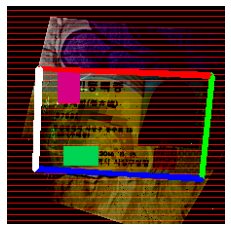

In [88]:
for image, y in dt:
    image = image[0]
    y_label = y[0][0]
    y_points = y[1][0]
    label, pred_points = model(image[None, ...])
    # print(y_points)
    print(y_points, pred_points)
    print(keras.losses.mse(y_points, pred_points))
    # points = decode_points(pred_points, tf.shape(image))
    image = draw_points(image.numpy(), y_points.numpy(), False)

    # points = decode_points(y_points, tf.shape(image))
    image = draw_points(image, pred_points[0].numpy(), False)
    
    plt.imshow(image)
    plt.axis('off')
    plt.plot()
    
    break

In [236]:
model = keras.models.load_model('asdf')